<a href="https://colab.research.google.com/github/EstevanRamos/ML_cryptocurrency_prediction/blob/main/ML_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import distutils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from keras.utils.vis_utils import plot_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Machine Learning/g-research-crypto-forecasting.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('g-research-crypto-forecasting')

In [ ]:
data_folder = "g-research-crypto-forecasting/"
crypto_df = pd.read_csv(data_folder + 'train.csv')

In [ ]:
crypto_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [ ]:
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


# Helper Methods

In [ ]:
def plot_results(history):
  fig, ax = plt.subplots()
  ax.plot(history.history['RMSE'],label = 'train')
  ax.plot(history.history['val_RMSE'],label = 'test')
  ax.set_title('RMSE')
  ax.legend(loc='lower right')
  fig, ax = plt.subplots()
  ax.plot(history.history['MAPE'],label = 'train')
  ax.plot(history.history['val_MAPE'],label = 'test')
  ax.set_title('MAPE')
  ax.legend(loc='lower right')
  fig, ax = plt.subplots()
  ax.plot(history.history['loss'],label = 'train')
  ax.plot(history.history['val_loss'],label = 'test')
  ax.set_title('MSE')
  ax.legend(loc='upper right')

In [ ]:
#function to conver d/m/y to time stamp making it easier to split data
def to_time_stamp(s):
  import time
  return np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [ ]:
#function to get the fixed coin data frame given coin id
def get_crypto_data(crypto_df, id):
  #creates specific coin df
  coin = crypto_df[crypto_df["Asset_ID"]==id].set_index("timestamp")

  #Replaces Null values
  coin.fillna(method ='ffill', inplace = True)

  #removes gaps in time
  coin = coin.reindex(range(coin.index[0],coin.index[-1]+60,60),method='pad')
  
  return coin

In [ ]:
#gets the coin data frame and converts it into numpy train test split (used for testing)
def get_split_data_random(coin):
  from sklearn.preprocessing import MinMaxScaler
  # Scalaing data is important
  scaler = MinMaxScaler()

  #converts df to numpy
  coin = coin.to_numpy()

  #gets target price
  y = coin[:, -1]

  #removes id column and target column
  X = np.delete(coin , (0,8), axis=1)

  #creates split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

  #scales data
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  return  X_train, X_test, y_train, y_test

In [ ]:
def get_split_data(coin):
  from sklearn.preprocessing import MinMaxScaler
  # Scalaing data is important
  scaler = MinMaxScaler()

  # 80/20 split for time 
  train_window = [to_time_stamp("01/01/2018"), to_time_stamp("23/12/2020")]
  test_window = [to_time_stamp("24/12/2020"), to_time_stamp("21/09/2021")]

  #Y is Target price
  Y = coin.Target

  #creates x_train and x_test with the time windows
  X_train = coin.loc[train_window[0]:train_window[1]].to_numpy()
  X_test = coin.loc[test_window[0]:test_window[1]].to_numpy()

  #we remove the id and target col from X
  X_train = np.delete(X_train, (0,8), axis = 1)
  X_test = np.delete(X_test, (0,8), axis = 1)

  #create Y with time windows
  y_train = Y.loc[train_window[0]:train_window[1]].to_numpy()
  y_test = Y.loc[test_window[0]:test_window[1]].to_numpy()

  #scale the data
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  return X_train, X_test, y_train, y_test


In [ ]:
#Given a coin dataframe, prints out random forest regression results
def randomForestRegression(coin):
  from sklearn.ensemble import RandomForestRegressor
  #gets data
  X_train, X_test, y_train, y_test = get_split_data(coin)

  #creates random forest
  RF = RandomForestRegressor(n_estimators= 50 , max_depth = 10)
  RF.fit(X_train , y_train)
  
  #predicts targets
  pred = RF.predict(X_test)

  print('Mean absolute error: {:.4f}'.format(mean_absolute_error(y_test,pred)))
  print('Mean squared error: {:.4f}'.format(mean_squared_error(y_test,pred)))


In [ ]:
def linearRegression(coin):
  from sklearn.linear_model import LinearRegression
  X_train, X_test, y_train, y_test = get_split_data(coin)

  LR = LinearRegression()
  LR.fit(X_train, y_train)
  pred = LR.predict(X_test)
  print('Mean Squared error: {:.10f}'.format(mean_squared_error(y_test,pred)))
  print('Test score for LR baseline:', f"{np.corrcoef(pred, y_test)[0,1]:.10f}")

# Baselines for BTC , ETH , LTC

In [ ]:
btc = get_crypto_data(crypto_df , 1)
print("Metrics for BTC:")
linearRegression(btc)
print()
print("Metrics for ETH:")
eth = get_crypto_data(crypto_df , 6)
linearRegression(eth)
print()
print("Metrics for LTC:")
ltc = get_crypto_data(crypto_df , 9)
linearRegression(ltc)
print()

Metrics for BTC:
Mean Squared error: 0.0000064366
Test score for LR baseline: 0.0077411506

Metrics for ETH:
Mean Squared error: 0.0000085400
Test score for LR baseline: 0.0077458411

Metrics for LTC:
Mean Squared error: 0.0000160751
Test score for LR baseline: -0.0038230615



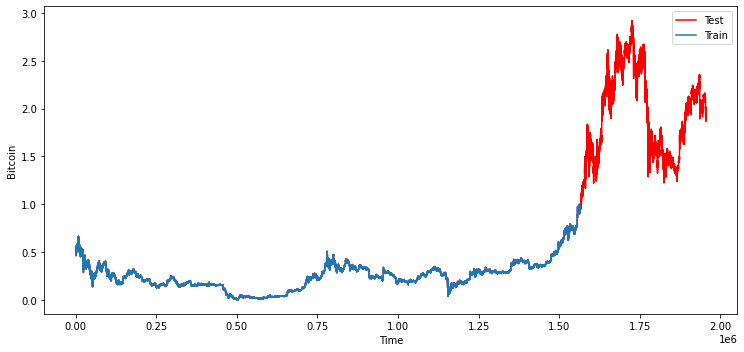

In [ ]:
btc = get_crypto_data(crypto_df , 1)
X_train, X_test, y_train, y_test = get_split_data(btc)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,5))

ax = f.add_subplot(131)
combined = np.concatenate([X_train[:,4],X_test[:,4]])
plt.plot(combined,color = 'red' ,label='Test')
ax.plot(X_train[:,4], label='Train')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

plt.tight_layout()
plt.show()

# Code for drawing graphs

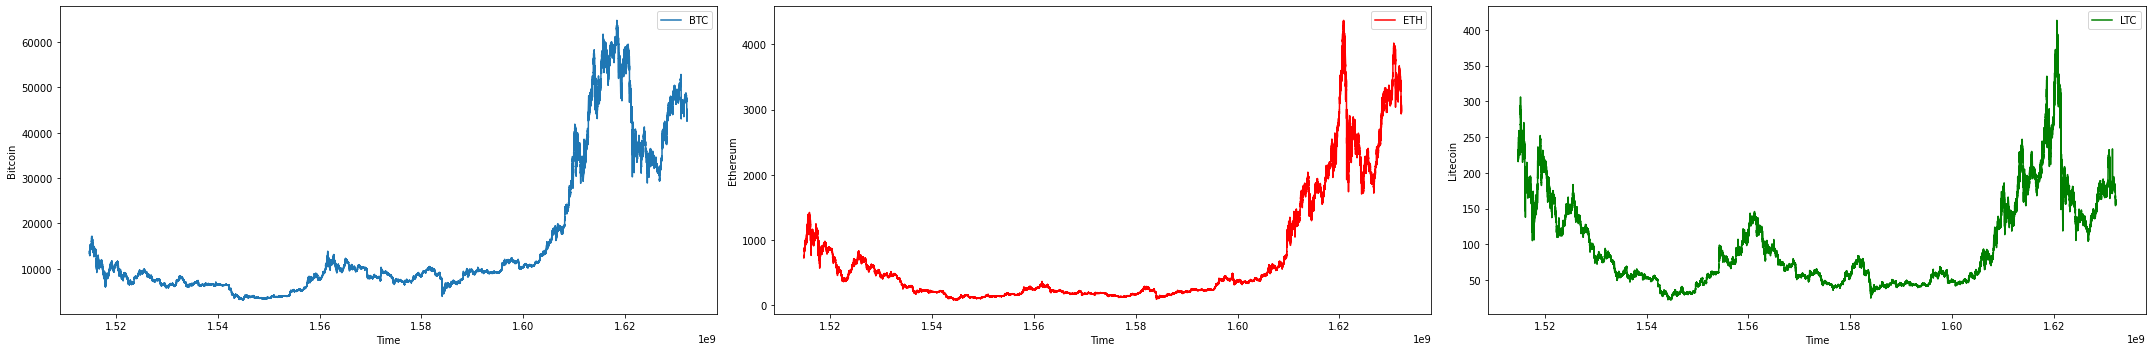

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,5))

ax = f.add_subplot(131)
plt.plot(btc['Close'], label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(132)
ax2.plot(eth['Close'], color='red', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

ax3 = f.add_subplot(133)
ax3.plot(ltc['Close'], color='green', label='LTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Litecoin')

plt.tight_layout()
plt.show()


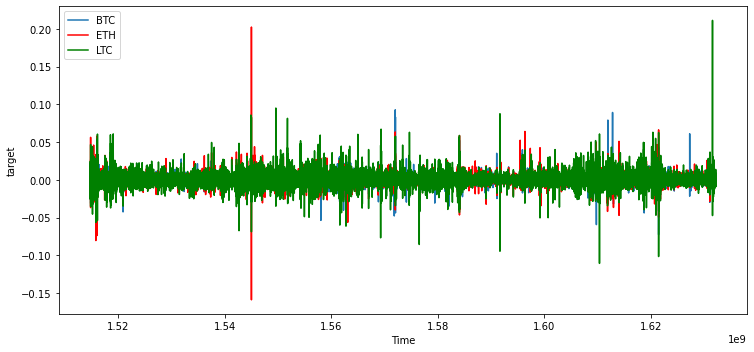

In [ ]:
f = plt.figure(figsize=(30,5))

ax = f.add_subplot(131)
plt.plot(btc['Target'], label='BTC')
ax.plot(eth['Target'], color='red', label='ETH')
ax.plot(ltc['Target'], color='green', label='LTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('target')

plt.tight_layout()
plt.show()

In [ ]:
btc = get_crypto_data(crypto_df , 1)
X_train, X_test, y_train, y_test = get_split_data(btc)

In [ ]:
eth = get_crypto_data(crypto_df , 6)
X_train, X_test, y_train, y_test = get_split_data(eth)

In [ ]:
ltc = get_crypto_data(crypto_df , 9)
X_train, X_test, y_train, y_test = get_split_data(ltc)

In [ ]:
def dense_model(inputs = 7,hidden_1=512, hidden_2=256):
  model = tf.keras.models.Sequential()
  model.add(Dense(hidden_1, input_shape=(inputs,)))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(hidden_2))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(128))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(64))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(1))
  return model

dense = dense_model()
dense.summary() 
dense.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE") , "MAPE"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4096      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [ ]:
history = dense.fit(
    X_train, y_train,
    epochs =  10, 
    batch_size= 2048, 
    verbose = 1,
    validation_data=(X_test, y_test),
)


print('Final accuracy on training set: {:.10f}'.format(history.history['loss'][-1]))
print('Final accuracy on test set: {:.10f}'.format(history.history['val_loss'][-1]))
print('Mean Squared Error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_loss'][-5:])))
print('Mean Root Mean Squared error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_RMSE'][-5:])))
print('Mean Apolute Percentage error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_MAPE'][-5:])))

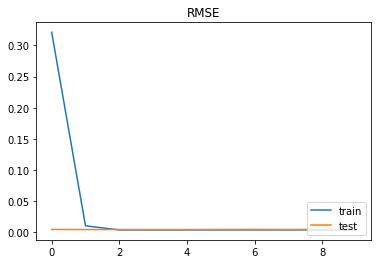

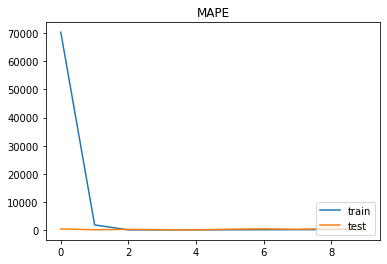

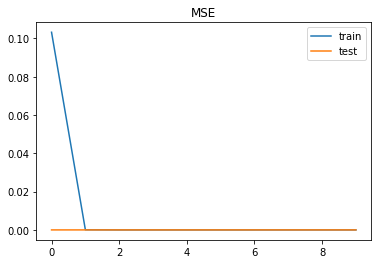

In [ ]:
plot_results(history)

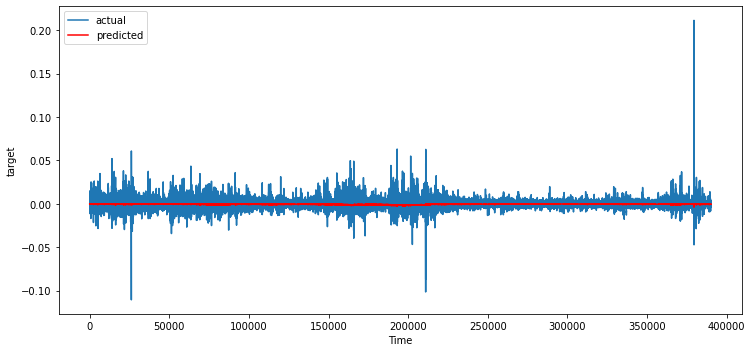

In [ ]:
pred = dense(X_test).numpy()
pred= pred.reshape(-1)

f = plt.figure(figsize=(30,5))

ax = f.add_subplot(131)
ax.plot(y_test, label = 'actual')
ax.plot(pred , label = 'predicted' , color = 'red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('target')

plt.tight_layout()
plt.show()

# Data Augmentation

In [ ]:
#adds upper shadow, lowershadow, high/low, and open - close to data 
def get_features(df):
    df_feat = df[['Asset_ID','Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].copy()
    df_feat['upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df_feat['lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat["open_sub_close"] = df_feat["Open"] - df_feat["Close"]
    return df_feat

In [ ]:
def rolling_mean(series, window): return series.rolling(window).mean()
def rolling_std(series, window): return series.rolling(window).std()
def rolling_sum(series, window): return series.rolling(window).sum()
def ewma(series, span, min_periods): return series.ewm(span = span, min_periods = min_periods).mean()

In [ ]:
#Moving Average
def MA(df, n = 15):
    MA = pd.Series(rolling_mean(df['Close'], n), name = 'MA_' + str(n))
    df['MA'] = MA
    return df

#Exponential Moving Average
def EMA(df, n = 15):
    EMA = pd.Series(ewma(df['Close'], span = n, min_periods = n - 1), name = 'EMA_' + str(n))
    df['EMA'] = EMA
    return df

#Momentum
def MOM(df, n = 15):
    M = pd.Series(df['Close'].diff(n), name = 'Momentum_' + str(n))
    df['MOM'] = M
    return df

#Rate of Change
def ROC(df, n = 15):
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name = 'ROC_' + str(n))
    df['ROC'] = ROC
    return df


#after you call these you have to use .fillna(method = 'bfill')

# Testing Data Augmentation

In [ ]:
btc = get_crypto_data(crypto_df , 1)
btc = get_features(btc)
btc = MA(btc)
btc = EMA(btc)
btc = MOM(btc)
btc = ROC(btc)

btc.fillna(method = 'bfill' , inplace = True)
btc_X_train, btc_X_test, btc_y_train, btc_y_test = get_split_data(btc)

In [ ]:
eth = get_crypto_data(crypto_df , 6)
eth = get_features(btc)
eth = MA(eth)
eth = EMA(eth)
eth = MOM(eth)
eth = ROC(eth)

eth.fillna(method = 'bfill' , inplace = True)
eth_X_train, eth_X_test, eth_y_train, eth_y_test = get_split_data(eth)

In [ ]:
ltc = get_crypto_data(crypto_df , 9)
ltc = get_features(ltc)
ltc = MA(ltc)
ltc = EMA(ltc)
ltc = MOM(ltc)
ltc = ROC(ltc)

ltc.fillna(method = 'bfill' , inplace = True)
ltc_X_train, ltc_X_test, ltc_y_train, ltc_y_test = get_split_data(ltc)

In [ ]:
def dense_model(inputs = 7,hidden_1=512, hidden_2=256):
  model = tf.keras.models.Sequential()
  model.add(Dense(hidden_1, input_shape=(inputs,)))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(hidden_2))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(128))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(64))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(1))
  return model

dense = dense_model(inputs=14)
dense.summary() 
dense.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE") , "MAPE"])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 512)               7680      
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_32 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_41 (Dense)            (None, 256)               131328    
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_33 (Bat  (None, 256)              1024      
 chNormalization)                                     

In [ ]:
history = dense.fit(
    btc_X_train, btc_y_train,
    epochs =  10, 
    batch_size= 2048, 
    verbose = 1,
    validation_data=(btc_X_test, btc_y_test),
)


print('Final accuracy on training set: {:.10f}'.format(history.history['loss'][-1]))
print('Final accuracy on test set: {:.10f}'.format(history.history['val_loss'][-1]))
print('Mean Squared Error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_loss'][-5:])))
print('Mean Root Mean Squared error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_RMSE'][-5:])))
print('Mean Apolute Percentage error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_MAPE'][-5:])))

Epoch 1/10
765/765 [==============================] - 11s 15ms/step - loss: 3.9088e-06 - RMSE: 0.0020 - MAPE: 367.6672 - val_loss: 6.4630e-06 - val_RMSE: 0.0025 - val_MAPE: 308.4181
Epoch 2/10
765/765 [==============================] - 11s 15ms/step - loss: 4.2640e-06 - RMSE: 0.0021 - MAPE: 467.7773 - val_loss: 4.2099e-05 - val_RMSE: 0.0065 - val_MAPE: 3481.7952
Epoch 3/10
765/765 [==============================] - 11s 15ms/step - loss: 4.1865e-06 - RMSE: 0.0020 - MAPE: 456.4111 - val_loss: 1.6451e-04 - val_RMSE: 0.0128 - val_MAPE: 7315.0146
Epoch 4/10
765/765 [==============================] - 11s 15ms/step - loss: 4.2367e-06 - RMSE: 0.0021 - MAPE: 463.8040 - val_loss: 1.2669e-04 - val_RMSE: 0.0113 - val_MAPE: 6385.3745
Epoch 5/10
765/765 [==============================] - 12s 15ms/step - loss: 4.2008e-06 - RMSE: 0.0020 - MAPE: 483.3719 - val_loss: 7.4638e-06 - val_RMSE: 0.0027 - val_MAPE: 676.2129
Epoch 6/10
765/765 [==============================] - 12s 15ms/step - loss: 4.0551e-06 

In [ ]:
history = dense.fit(
    eth_X_train, eth_y_train,
    epochs =  10, 
    batch_size= 2048, 
    verbose = 1,
    validation_data=(eth_X_test, eth_y_test),
)


print('Final accuracy on training set: {:.10f}'.format(history.history['loss'][-1]))
print('Final accuracy on test set: {:.10f}'.format(history.history['val_loss'][-1]))
print('Mean Squared Error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_loss'][-5:])))
print('Mean Root Mean Squared error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_RMSE'][-5:])))
print('Mean Apolute Percentage error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_MAPE'][-5:])))

Epoch 1/10
765/765 [==============================] - 12s 15ms/step - loss: 3.9493e-06 - RMSE: 0.0020 - MAPE: 380.1080 - val_loss: 1.3408e-04 - val_RMSE: 0.0116 - val_MAPE: 6575.6729
Epoch 2/10
765/765 [==============================] - 12s 15ms/step - loss: 4.2537e-06 - RMSE: 0.0021 - MAPE: 466.6099 - val_loss: 1.2279e-04 - val_RMSE: 0.0111 - val_MAPE: 6310.1104
Epoch 3/10
765/765 [==============================] - 12s 15ms/step - loss: 4.2376e-06 - RMSE: 0.0021 - MAPE: 470.9196 - val_loss: 1.4463e-04 - val_RMSE: 0.0120 - val_MAPE: 6833.8335
Epoch 4/10
765/765 [==============================] - 12s 15ms/step - loss: 4.2897e-06 - RMSE: 0.0021 - MAPE: 494.2488 - val_loss: 2.3380e-05 - val_RMSE: 0.0048 - val_MAPE: 2436.7532
Epoch 5/10
765/765 [==============================] - 11s 15ms/step - loss: 4.1802e-06 - RMSE: 0.0020 - MAPE: 483.5397 - val_loss: 8.9887e-05 - val_RMSE: 0.0095 - val_MAPE: 5309.1870
Epoch 6/10
765/765 [==============================] - 11s 14ms/step - loss: 4.1880e-0

In [ ]:
history = dense.fit(
    ltc_X_train, ltc_y_train,
    epochs =  10, 
    batch_size= 2048, 
    verbose = 1,
    validation_data=(ltc_X_test, ltc_y_test),
)


print('Final accuracy on training set: {:.10f}'.format(history.history['loss'][-1]))
print('Final accuracy on test set: {:.10f}'.format(history.history['val_loss'][-1]))
print('Mean Squared Error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_loss'][-5:])))
print('Mean Root Mean Squared error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_RMSE'][-5:])))
print('Mean Apolute Percentage error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_MAPE'][-5:])))

Epoch 1/10
765/765 [==============================] - 11s 15ms/step - loss: 6.8281e-07 - RMSE: 8.2633e-04 - MAPE: 149.0102 - val_loss: 2.1214e-08 - val_RMSE: 1.4565e-04 - val_MAPE: 40.4957
Epoch 2/10
765/765 [==============================] - 12s 15ms/step - loss: 5.6355e-07 - RMSE: 7.5070e-04 - MAPE: 145.6690 - val_loss: 9.2331e-08 - val_RMSE: 3.0386e-04 - val_MAPE: 40.3049
Epoch 3/10
765/765 [==============================] - 12s 15ms/step - loss: 5.0920e-07 - RMSE: 7.1358e-04 - MAPE: 123.8669 - val_loss: 4.0722e-07 - val_RMSE: 6.3814e-04 - val_MAPE: 241.3872
Epoch 4/10
765/765 [==============================] - 11s 15ms/step - loss: 4.2358e-07 - RMSE: 6.5083e-04 - MAPE: 113.9955 - val_loss: 6.2138e-07 - val_RMSE: 7.8828e-04 - val_MAPE: 223.6984
Epoch 5/10
765/765 [==============================] - 12s 15ms/step - loss: 3.7454e-07 - RMSE: 6.1199e-04 - MAPE: 99.9254 - val_loss: 4.6726e-07 - val_RMSE: 6.8357e-04 - val_MAPE: 245.7703
Epoch 6/10
765/765 [==============================] -

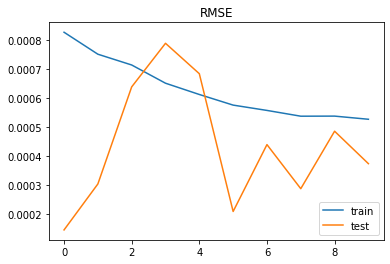

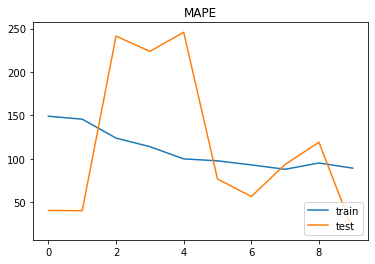

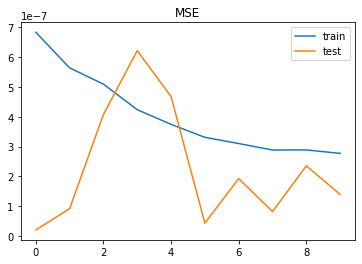

In [ ]:
plot_results(history)

# Combining Multiple coins

In [ ]:
all_X_train = np.concatenate((btc_X_train, eth_X_train , ltc_X_train), axis=0)
all_X_test = np.concatenate((btc_X_test, eth_X_test , ltc_X_test), axis=0)

all_y_train = np.concatenate((btc_y_train, eth_y_train , ltc_y_train), axis=0)
all_y_test = np.concatenate((btc_y_test, eth_y_test , ltc_y_test), axis=0)

In [ ]:
def dense_model(inputs = 7,hidden_1=512, hidden_2=256):
  model = tf.keras.models.Sequential()
  model.add(Dense(hidden_1, input_shape=(inputs,)))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(hidden_2))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(128))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(64))
  model.add(Dropout(.25))
  model.add(BatchNormalization())
  model.add(Dense(1))
  return model

dense = dense_model(inputs=14)
dense.summary() 
dense.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE") , "MAPE"])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 512)               7680      
                                                                 
 dropout_28 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_28 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 256)               131328    
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_29 (Bat  (None, 256)              1024      
 chNormalization)                                     

In [ ]:
history = dense.fit(
    all_X_train, all_y_train,
    epochs =  10, 
    batch_size= 2048, 
    verbose = 1,
    validation_data=(all_X_test, all_y_test),
)


print('Final accuracy on training set: {:.10f}'.format(history.history['loss'][-1]))
print('Final accuracy on test set: {:.10f}'.format(history.history['val_loss'][-1]))
print('Mean Squared Error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_loss'][-5:])))
print('Mean Root Mean Squared error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_RMSE'][-5:])))
print('Mean Apolute Percentage error in last 5 epochs: {:.10f}'.format(np.mean(history.history['val_MAPE'][-5:])))

Epoch 1/10
2293/2293 [==============================] - 33s 14ms/step - loss: 7.9707e-07 - RMSE: 8.9279e-04 - MAPE: 255.5921 - val_loss: 1.6850e-05 - val_RMSE: 0.0041 - val_MAPE: 1330.4821
Epoch 2/10
2293/2293 [==============================] - 33s 14ms/step - loss: 5.7121e-07 - RMSE: 7.5578e-04 - MAPE: 195.6709 - val_loss: 1.6100e-05 - val_RMSE: 0.0040 - val_MAPE: 1187.3997
Epoch 3/10
2293/2293 [==============================] - 33s 14ms/step - loss: 4.9953e-07 - RMSE: 7.0678e-04 - MAPE: 179.6551 - val_loss: 1.6313e-05 - val_RMSE: 0.0040 - val_MAPE: 1118.0942
Epoch 4/10
2293/2293 [==============================] - 33s 15ms/step - loss: 4.8573e-07 - RMSE: 6.9694e-04 - MAPE: 176.8596 - val_loss: 1.0137e-05 - val_RMSE: 0.0032 - val_MAPE: 861.6619
Epoch 5/10
2293/2293 [==============================] - 34s 15ms/step - loss: 4.6605e-07 - RMSE: 6.8268e-04 - MAPE: 175.7270 - val_loss: 1.0440e-05 - val_RMSE: 0.0032 - val_MAPE: 876.7526
Epoch 6/10
2293/2293 [==============================] - 3

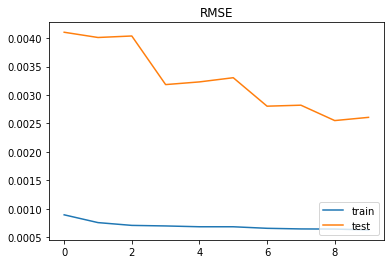

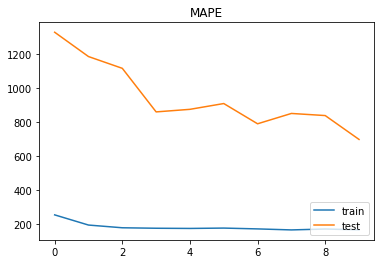

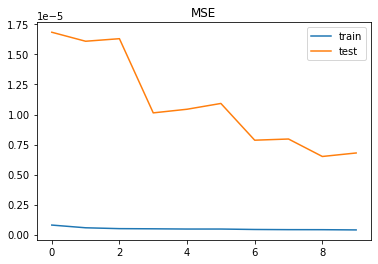

In [ ]:
plot_results(history)

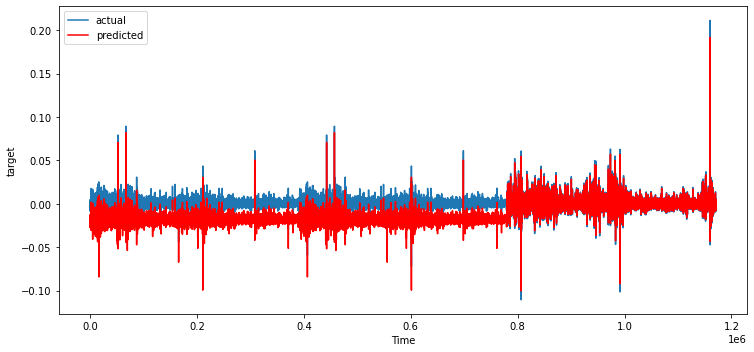

In [ ]:
pred = dense(all_X_test).numpy()
pred= pred.reshape(-1)

f = plt.figure(figsize=(30,5))

ax = f.add_subplot(131)
ax.plot(all_y_test, label = 'actual')
ax.plot(pred , label = 'predicted' , color = 'red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('target')

plt.tight_layout()
plt.show()